In [1]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import math
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
%matplotlib inline

In [3]:
!unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!mv rus.txt eng-rus.txt

In [ ]:
!tail eng-rus.txt

I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I asked when you took a chance on me eight years ago. I'm asking you to believe, not in my ability to bring about change but in yours.	У меня же, как у вашего президента, есть к вам последняя просьба. Та же самая, что и восемь лет назад, когда вы оказали мне своё доверие. Я прошу вас верить, но не в мои способности добиться перемен, а в ваши.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762723 (BHO) & #6390123 (odexed)
In today's world, we have to equip 

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    parts = s.split('\t')[:2]

    result = []
    for part in parts:
        normalized = unicodedata.normalize('NFC', part)
        result.append(normalized)
        
    return '\t'.join(result)

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Яйё.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 30087 sentence pairs
Counting words...
Counted words:
rus 10529
eng 4377
['ты в этом не силён .', 'you re not good at this .']


The Encoder
-----------





In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, model_type="GRU"):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type

        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        if self.model_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

The Decoder
-----------




In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, model_type="GRU"):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type

        self.embedding = nn.Embedding(output_size, hidden_size)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.softmax(self.out(output.squeeze(1)))
        return output, hidden

    def initHidden(self, batch_size=1):
        if self.model_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(batch_size, max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden)
        encoder_outputs[:, ei, :] = encoder_output.squeeze(1)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device).view(batch_size, 1)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[:, di, :].squeeze(1))
            decoder_input = target_tensor[:, di, :] # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach() # detach from history as input

            loss += criterion(decoder_output, target_tensor[:, di, :].squeeze(1))
            if (decoder_input == EOS_token).any():
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
plt.switch_backend('agg')
import matplotlib.ticker as ticker


def showPlot(iterations, points, name):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc_y = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc_y)
    ax.plot(iterations, points)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs Iterations')
    plt.savefig(name)
    plt.close()

In [15]:
def trainIters(encoder, decoder, n_iters, name, batch_size=8, print_every=1000, plot_every=1000, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    iterations = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    input_tensors = nn.utils.rnn.pad_sequence([pair[0] for pair in training_pairs], batch_first=True, padding_value=0)
    target_tensors = nn.utils.rnn.pad_sequence([pair[1] for pair in training_pairs], batch_first=True, padding_value=0)
    dataset = TensorDataset(input_tensors, target_tensors)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.NLLLoss()
    iter_count = 0

    for _ in range(1, (n_iters // batch_size) + 1):
        for batch_input, batch_target in dataloader:
            if iter_count >= n_iters:
                break

            loss = train(batch_input, batch_target, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss * batch_input.size(0)
            plot_loss_total += loss * batch_input.size(0)
            iter_count += batch_input.size(0)

            if iter_count % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter_count / n_iters), iter_count, iter_count / n_iters * 100, print_loss_avg))

            if iter_count % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                iterations.append(iter_count)
                plot_loss_total = 0

    showPlot(iterations, plot_losses, name=name)

    return plot_losses

In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.view(1, -1, 1)
        input_length = input_tensor.size(1)

        encoder_hidden = encoder.initHidden(batch_size=1)

        encoder_outputs = torch.zeros(1, max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden)
            encoder_outputs[:, ei, :] = encoder_output.squeeze(1)

        decoder_input = torch.tensor([[SOS_token]], device=device).view(1, 1)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.view(1, 1).detach()

        return decoded_words

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [27]:
hidden_size = 256
batch_size = 1
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

losses_gru_1_layer = trainIters(encoder1, decoder1, 100000, batch_size=batch_size, print_every=10000, plot_every=10000, name='GRU_1_layer.png')

2m 1s (- 18m 15s) (10000 10%) 2.4381
3m 58s (- 15m 52s) (20000 20%) 1.9237
5m 52s (- 13m 43s) (30000 30%) 1.7019
7m 52s (- 11m 48s) (40000 40%) 1.5405
9m 48s (- 9m 48s) (50000 50%) 1.3952
11m 44s (- 7m 49s) (60000 60%) 1.2749
13m 38s (- 5m 50s) (70000 70%) 1.1887
15m 35s (- 3m 53s) (80000 80%) 1.1077
17m 31s (- 1m 56s) (90000 90%) 1.0561
19m 27s (- 0m 0s) (100000 100%) 0.9891


In [36]:
evaluateRandomly(encoder1, decoder1, 20)

> завтра я буду играть в футбол .
= i am going to play soccer tomorrow .
< i m going to play tomorrow tomorrow . <EOS>

> мы попусту тратим время .
= we re wasting time .
< we re wasting time time time . <EOS>

> я так за это благодарен .
= i m so grateful for that .
< i m so grateful for that that . . <EOS>

> я богатый .
= i m rich .
< i m going to australia this next year . <EOS>

> вы то мне и нужны .
= you re the one i need now .
< you re tired and i me i . <EOS>

> надеюсь мы тебе не мешаем .
= we re not disturbing you i hope .
< we re not as we can you . . <EOS>

> прости я не могу тебе помочь .
= i m sorry i can t help you .
< i m sorry i can t help you . <EOS>

> я очень рад за тома .
= i m very happy for tom .
< i m really happy for tom tom . <EOS>

> я не занят сегодня вечером .
= i m not busy tonight .
< i m not so tired this evening . <EOS>

> вы будете знаменитыми .
= you re going to be famous .
< you re going to be working this . . <EOS>

> мне понадобится несколько добр

In [35]:
pd.DataFrame({
    'iterations': np.arange(start=10000, stop=110000, step=10000),
    'losses': losses_gru_1_layer
}).to_csv('losses_GRU_1_layer.csv')

# **The RNN with 2 GRU layers**

In [37]:
hidden_size = 256
batch_size = 1
encoder2 = EncoderRNN(input_lang.n_words, hidden_size, num_layers=2).to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words, num_layers=2).to(device)

losses_gru_2_layers = trainIters(encoder2, decoder2, 100000, batch_size=batch_size, print_every=10000, plot_every=10000, name='GRU_2_layer.png')

2m 31s (- 22m 42s) (10000 10%) 2.3870
4m 54s (- 19m 39s) (20000 20%) 1.9418
7m 16s (- 16m 58s) (30000 30%) 1.7025
9m 43s (- 14m 35s) (40000 40%) 1.5286
12m 8s (- 12m 8s) (50000 50%) 1.3752
14m 35s (- 9m 43s) (60000 60%) 1.2390
17m 3s (- 7m 18s) (70000 70%) 1.1230
19m 30s (- 4m 52s) (80000 80%) 1.0522
21m 59s (- 2m 26s) (90000 90%) 0.9665
24m 27s (- 0m 0s) (100000 100%) 0.9149


In [40]:
evaluateRandomly(encoder2, decoder2, 20)

> он настроен довольно оптимистично .
= he is rather optimistic .
< he is very busy it well . <EOS>

> она постелила на стол скатерть .
= she spread a cloth over the table .
< she is on to to on the . . <EOS>

> теперь ты один из нас .
= you re now one of us .
< you re now now now old now . <EOS>

> мы на нужном этаже .
= we re on the right floor .
< we are on the minutes of the . <EOS>

> мы подумываем о переезде .
= we re thinking about moving .
< we re thinking about our it . . <EOS>

> я пытаюсь сохранить тебе жизнь .
= i m trying to keep you alive .
< i m trying to to to your money . <EOS>

> ты очень застенчивый .
= you re very shy .
< you re very very very you too . <EOS>

> он с нетерпением этого ждёт .
= he is looking forward to it .
< he is looking forward to it it . <EOS>

> мы точно не знаем что это значит .
= we re not sure what it means .
< we re not sure what it means . <EOS>

> я звоню чтобы сказать вам спасибо .
= i m calling to thank you .
< i m calling to thank you .

In [41]:
pd.DataFrame({
    'iterations': np.arange(start=10000, stop=110000, step=10000),
    'losses': losses_gru_2_layers
}).to_csv('losses_GRU_2_layer.csv')

# **The RNN with 2 GRU layers with batches**

In [42]:
hidden_size = 256
batch_size = 16
encoder3 = EncoderRNN(input_lang.n_words, hidden_size, num_layers=2).to(device)
decoder3 = DecoderRNN(hidden_size, output_lang.n_words, num_layers=2).to(device)

losses_gru_2_layers_with_batches = trainIters(
    encoder3, decoder3, 600000, batch_size=batch_size, print_every=60000, plot_every=60000, name='GRU_2_layer_with_batches.png'
)

1m 32s (- 13m 51s) (60000 10%) 2.2331
2m 25s (- 9m 40s) (120000 20%) 1.7802
3m 17s (- 7m 40s) (180000 30%) 1.5841
4m 10s (- 6m 15s) (240000 40%) 1.4402
5m 3s (- 5m 3s) (300000 50%) 1.3194
5m 57s (- 3m 58s) (360000 60%) 1.2258
6m 50s (- 2m 55s) (420000 70%) 1.1317
7m 43s (- 1m 55s) (480000 80%) 1.0455
8m 36s (- 0m 57s) (540000 90%) 0.9758
9m 28s (- 0m 0s) (600000 100%) 0.9015


In [61]:
evaluateRandomly(encoder3, decoder3, 20)

> вы идиот .
= you re an idiot .
< you re making me and you are that . <EOS>

> я единственная кому ты можешь доверять .
= i m the only one you can trust .
< i m the only one you can trust . <EOS>

> я уже не голоден .
= i m no longer hungry .
< i m not hungry anymore anymore now . <EOS>

> ты ошибаешься .
= you re wrong .
< you re wrong about what you ? <EOS>

> я отпускаю бороду .
= i m growing a beard .
< i m beginning to meet french . <EOS>

> я не уверена что том готов .
= i m not sure tom is ready .
< i m not sure tom will be here . <EOS>

> я готова вам помочь .
= i m ready to help you .
< i m ready to help you here . <EOS>

> я не об этом .
= i m not talking about that .
< i m not talking about that . <EOS>

> он лежит на скамейке .
= he is lying on the bench .
< he is working on his room . <EOS>

> прости что наорал на тебя вчера .
= i m sorry for yelling at you yesterday .
< i m sorry for what you have a job .

> я еду в центр города .
= i m going downtown .
< i m going to th

In [ ]:
pd.DataFrame({
    'iterations': np.arange(start=60000, stop=660000, step=60000),
    'losses': losses_gru_2_layers_with_batches
}).to_csv('losses_GRU_2_layer_with_batches.csv')

# **The RNN with 2 LSTM layers with batches**

In [62]:
hidden_size = 256
batch_size = 16
encoder4 = EncoderRNN(input_lang.n_words, hidden_size, num_layers=2, model_type="LSTM").to(device)
decoder4 = DecoderRNN(hidden_size, output_lang.n_words, num_layers=2, model_type="LSTM").to(device)

losses_lstm_2_layers_batches = trainIters(
    encoder4, decoder4, 600000, batch_size=batch_size, print_every=60000, plot_every=60000, name='LSTM_2_layer_with_batches.png'
)

1m 32s (- 13m 50s) (60000 10%) 2.3784
2m 26s (- 9m 46s) (120000 20%) 1.8262
3m 20s (- 7m 47s) (180000 30%) 1.6332
4m 14s (- 6m 22s) (240000 40%) 1.5111
5m 10s (- 5m 10s) (300000 50%) 1.3793
6m 6s (- 4m 4s) (360000 60%) 1.2707
7m 1s (- 3m 0s) (420000 70%) 1.1757
7m 57s (- 1m 59s) (480000 80%) 1.0851
8m 52s (- 0m 59s) (540000 90%) 1.0005
9m 49s (- 0m 0s) (600000 100%) 0.9299


In [63]:
evaluateRandomly(encoder4, decoder4, n=20)

> он готов к работе .
= he is ready to work .
< he is used to do this . <EOS>

> мы в порядке .
= we re fine .
< we re busy with tom . <EOS>

> мы вам не враги .
= we re not your enemy .
< we re not your like you are . <EOS>

> я твоя а ты мой .
= i am yours and you are mine .
< i m giving you my father . <EOS>

> ты к себе слишком строг .
= you re too hard on yourself .
< you re too old for this job . <EOS>

> ты из бостона так ведь ?
= you re from boston right ?
< you re busy from boston aren t you ? <EOS>

> ты действительно очень продуктивна сегодня .
= you are really very productive today .
< you re very very but today . <EOS>

> ему за сорок .
= he s over forty .
< he is about to his with . <EOS>

> я не уверен что том что то сделал .
= i m not sure tom did anything .
< i m not sure tom tom not here . <EOS>

> том я дома .
= i m home tom .
< i m thinking of tom s here . <EOS>

> она разведена .
= she s divorced .
< she is what she her her . <EOS>

> он устал смотреть телевизор .


In [64]:
pd.DataFrame({
    'iterations': np.arange(start=60000, stop=660000, step=60000),
    'losses': losses_lstm_2_layers_batches
}).to_csv('losses_LSTM_2_layer_with_batches.csv')

# **Results**

## **Learning without batches**

In [ ]:
df_without_batches = pd.read_csv('losses_GRU_1_layer.csv').loc[:, ['iterations', 'losses']]\
    .merge(pd.read_csv('losses_GRU_2_layer.csv').loc[:, ['iterations', 'losses']], 
          on='iterations', suffixes=('_gru_1_layer', '_gru_2_layer'))
df_without_batches

,iterations,losses_gru_1_layer,losses_gru_2_layer
0,10000,2.438052,2.386977
1,20000,1.923676,1.941801
2,30000,1.701919,1.702461
3,40000,1.540455,1.528623
4,50000,1.395160,1.375168
5,60000,1.274914,1.238966
6,70000,1.188735,1.123015
7,80000,1.107739,1.052250
8,90000,1.056065,0.966535
9,100000,0.989086,0.914892


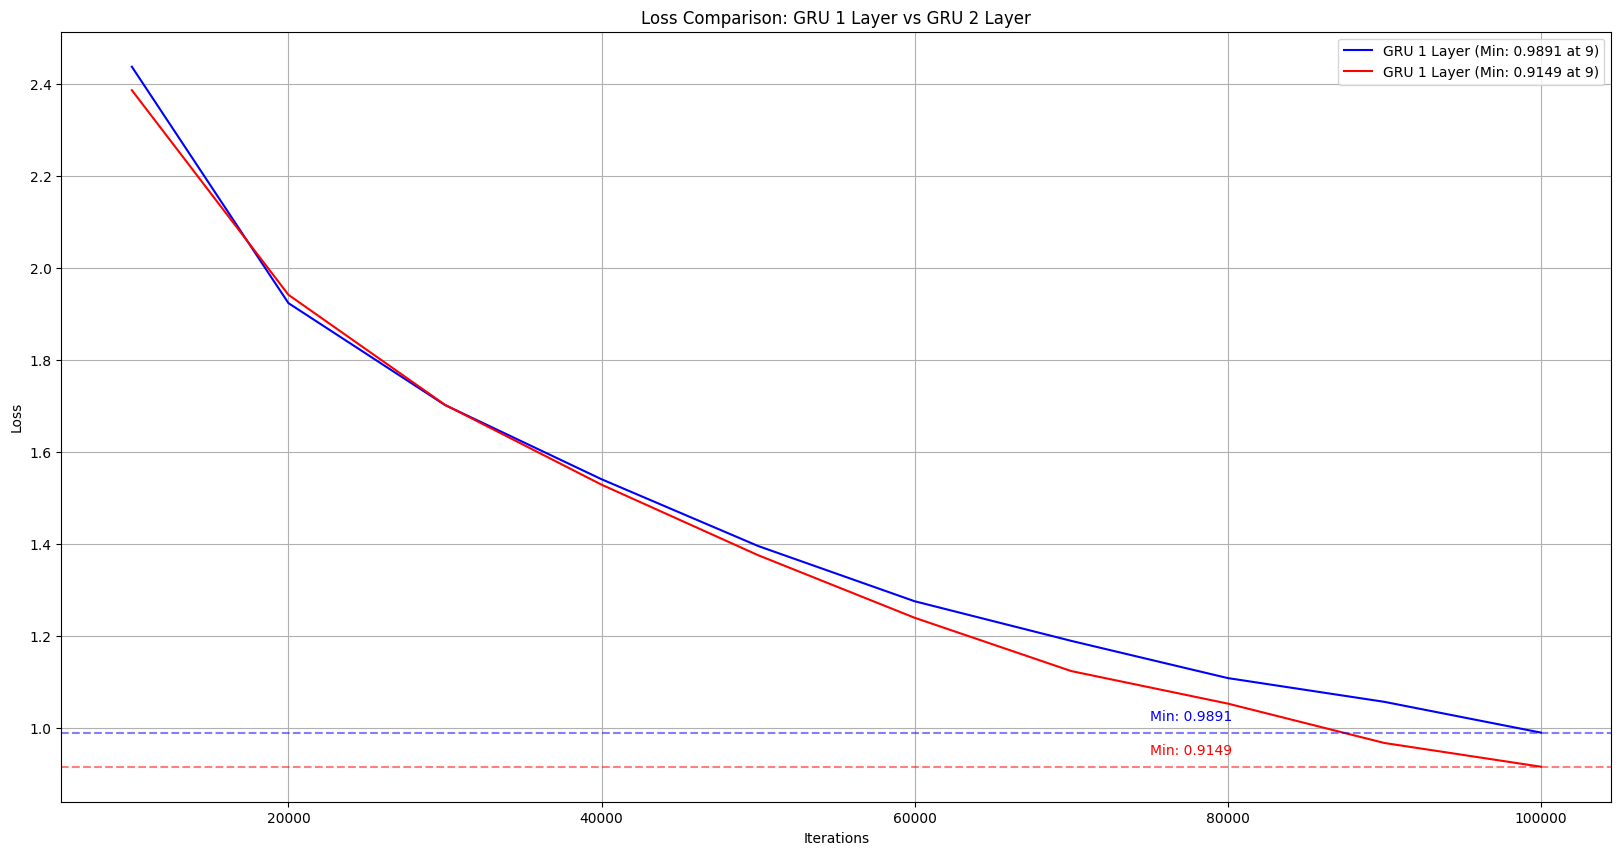

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(
    df_without_batches['iterations'], df_without_batches['losses_gru_1_layer'],
    label=f'GRU 1 Layer (Min: {min(df_without_batches['losses_gru_1_layer']):.4f} at {df_without_batches['losses_gru_1_layer'].idxmin()})',
    color='blue'
)
plt.plot(
    df_without_batches['iterations'], df_without_batches['losses_gru_2_layer'],
    label=f'GRU 1 Layer (Min: {min(df_without_batches['losses_gru_2_layer']):.4f} at {df_without_batches['losses_gru_2_layer'].idxmin()})',
    color='red'
)

plt.axhline(y=min(df_without_batches['losses_gru_1_layer']), color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=min(df_without_batches['losses_gru_2_layer']), color='red', linestyle='--', alpha=0.5)

plt.text(
    75000, min(df_without_batches['losses_gru_1_layer']) + 0.02, 
    f'Min: {min(df_without_batches['losses_gru_1_layer']):.4f}', 
    color='blue', ha='left', va='bottom'
)
plt.text(
    75000, min(df_without_batches['losses_gru_2_layer']) + 0.02, 
    f'Min: {min(df_without_batches['losses_gru_2_layer']):.4f}', 
    color='red', ha='left', va='bottom'
)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Comparison: GRU 1 Layer vs GRU 2 Layer')
plt.legend()
plt.grid(True)
plt.show()

## **Learning with batches**

In [32]:
df_with_batches = pd.read_csv('losses_GRU_2_layer_with_batches.csv').loc[:, ['iterations', 'losses']]\
    .merge(pd.read_csv('losses_LSTM_2_layer_with_batches.csv').loc[:, ['iterations', 'losses']], 
          on='iterations', suffixes=('_gru_2_layer_with_batches', '_lstm_2_layer_with_batches'))
df_with_batches

,iterations,losses_gru_2_layer_with_batches,losses_lstm_2_layer_with_batches
0,60000,1.940614,2.378394
1,120000,1.677536,1.826167
2,180000,1.516446,1.633247
3,240000,1.390096,1.511084
4,300000,1.270509,1.379327
5,360000,1.176743,1.270703
6,420000,1.090164,1.175737
7,480000,1.014410,1.085085
8,540000,0.951193,1.000509
9,600000,0.871196,0.929861


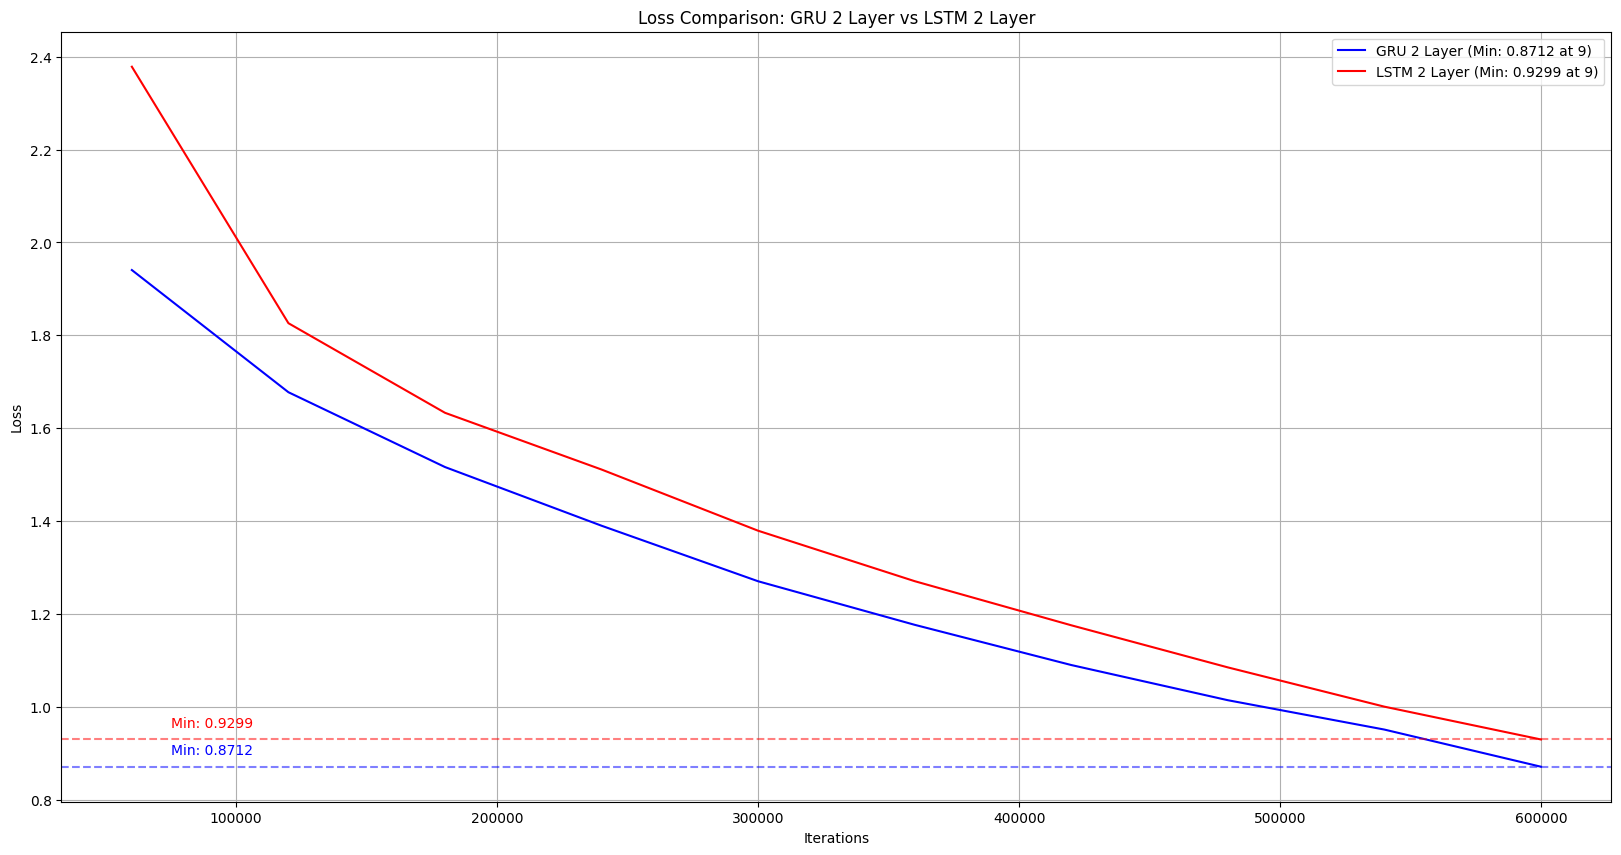

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(
    df_with_batches['iterations'], df_with_batches['losses_gru_2_layer_with_batches'],
    label=f'GRU 2 Layer (Min: {min(df_with_batches['losses_gru_2_layer_with_batches']):.4f} at {df_with_batches['losses_gru_2_layer_with_batches'].idxmin()})',
    color='blue'
)
plt.plot(
    df_with_batches['iterations'], df_with_batches['losses_lstm_2_layer_with_batches'],
    label=f'LSTM 2 Layer (Min: {min(df_with_batches['losses_lstm_2_layer_with_batches']):.4f} at {df_with_batches['losses_lstm_2_layer_with_batches'].idxmin()})',
    color='red'
)

plt.axhline(y=min(df_with_batches['losses_gru_2_layer_with_batches']), color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=min(df_with_batches['losses_lstm_2_layer_with_batches']), color='red', linestyle='--', alpha=0.5)

plt.text(
    75000, min(df_with_batches['losses_gru_2_layer_with_batches']) + 0.02, 
    f'Min: {min(df_with_batches['losses_gru_2_layer_with_batches']):.4f}', 
    color='blue', ha='left', va='bottom'
)
plt.text(
    75000, min(df_with_batches['losses_lstm_2_layer_with_batches']) + 0.02, 
    f'Min: {min(df_with_batches['losses_lstm_2_layer_with_batches']):.4f}', 
    color='red', ha='left', va='bottom'
)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Comparison: GRU 2 Layer vs LSTM 2 Layer')
plt.legend()
plt.grid(True)
plt.show()

# **The RNN with 2 GRU layers with batches final**

In [18]:
hidden_size = 256
batch_size = 16
encoder5 = EncoderRNN(input_lang.n_words, hidden_size, num_layers=2, model_type="GRU").to(device)
decoder5 = DecoderRNN(hidden_size, output_lang.n_words, num_layers=2, model_type="GRU").to(device)

losses_gru_2_layers_batches_final = trainIters(
    encoder5, decoder5, 1000000, batch_size=batch_size, print_every=100000, plot_every=100000, name='GRU_2_layer_with_batches_final.png'
)

2m 38s (- 23m 48s) (100000 10%) 2.0465
4m 9s (- 16m 38s) (200000 20%) 1.5827
5m 43s (- 13m 20s) (300000 30%) 1.3586
7m 17s (- 10m 56s) (400000 40%) 1.1873
8m 53s (- 8m 53s) (500000 50%) 1.0432
10m 28s (- 6m 59s) (600000 60%) 0.9153
12m 3s (- 5m 10s) (700000 70%) 0.8089
13m 39s (- 3m 24s) (800000 80%) 0.7187
15m 14s (- 1m 41s) (900000 90%) 0.6428
16m 50s (- 0m 0s) (1000000 100%) 0.5689


In [29]:
evaluateRandomly(encoder5, decoder5, n=20)

> я рад что вы знаете правду .
= i m glad you know the truth .
< i m glad you know the truth . <EOS>

> извини . я забыла об этом .
= i m sorry . i forgot about this .
< i m sorry . i forgot about this . <EOS>

> я рад что тебя послушал .
= i m glad i listened to you .
< i m glad i was to you . <EOS>

> я не настолько умный .
= i m not that smart .
< i m not so smart than i am . <EOS>

> я иду на юг .
= i m going south .
< i m going to my my room . <EOS>

> она на встрече .
= she s at a meeting .
< she is at a and english at home . <EOS>

> они не дают пройти .
= they are in the way .
< they are in the same way . <EOS>

> она старше тома .
= she s older than tom .
< she is two years older than tom . <EOS>

> я начинаю привыкать к этой жаре .
= i m getting used to this hot weather .
< i m getting used to this kind of work .

> я беспокойный .
= i m restless .
< i m aware . <EOS>

> мы беспокоимся за тебя .
= we re worried about you .
< we re worried about you about that . <EOS>

> ты мо

In [20]:
pd.DataFrame({
    'iterations': np.arange(start=100000, stop=1100000, step=100000),
    'losses': losses_gru_2_layers_batches_final
}).to_csv('losses_GRU_2_layer_with_batches_final.csv')

In [21]:
df_with_batches_final = pd.read_csv('losses_GRU_2_layer_with_batches_final.csv').loc[:, ['iterations', 'losses']]
df_with_batches_final

,iterations,losses
0,100000,2.046508
1,200000,1.582700
2,300000,1.358642
3,400000,1.187330
4,500000,1.043197
5,600000,0.915279
6,700000,0.808931
7,800000,0.718721
8,900000,0.642824
9,1000000,0.568896


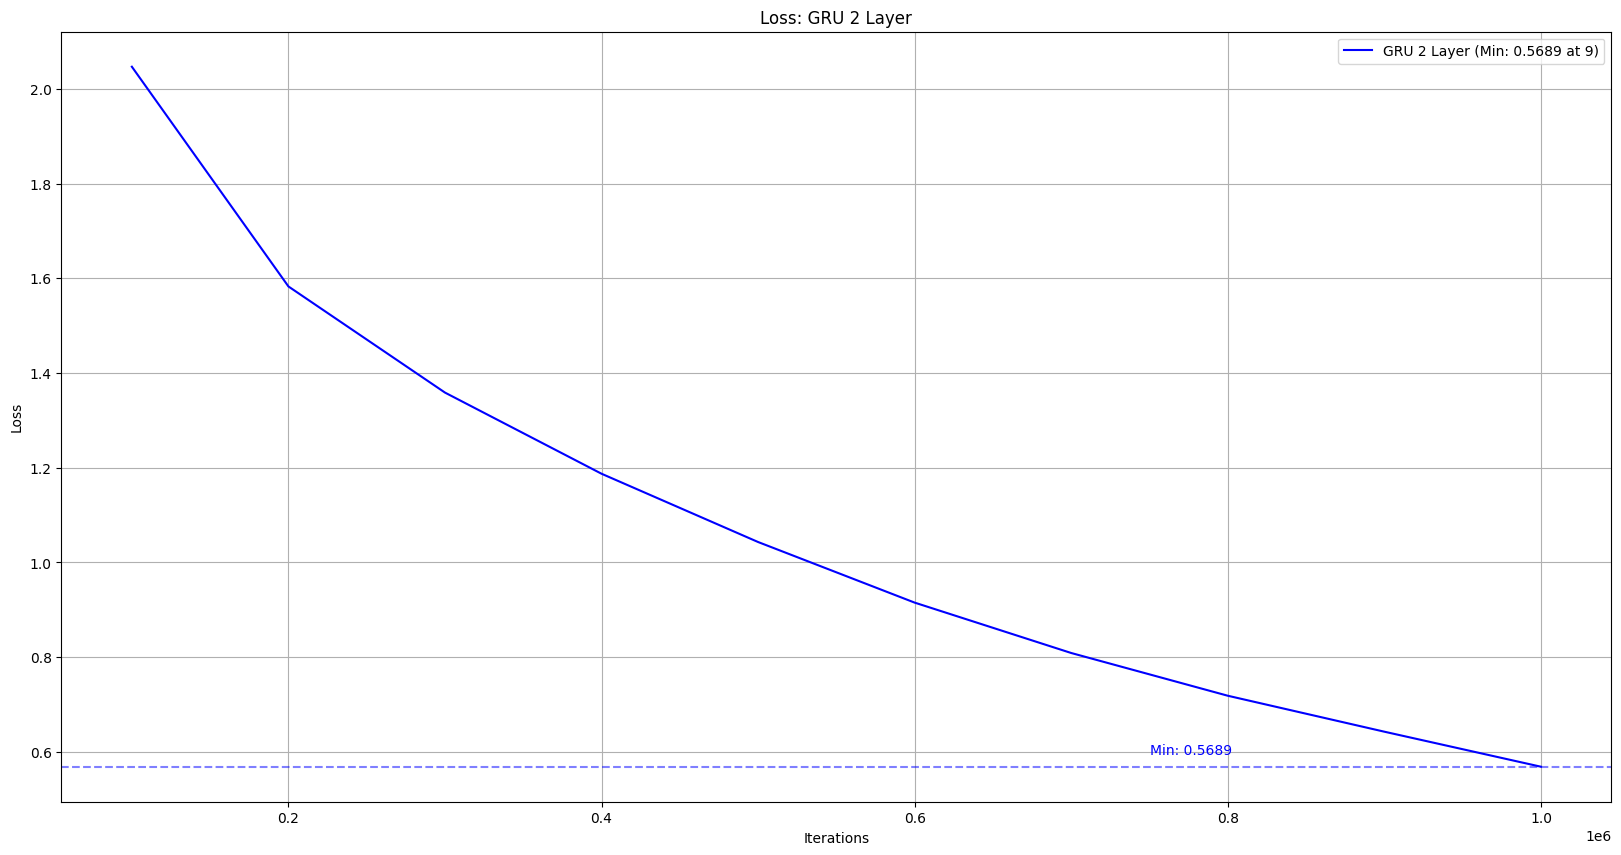

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(
    df_with_batches_final['iterations'], df_with_batches_final['losses'],
    label=f'GRU 2 Layer (Min: {min(df_with_batches_final['losses']):.4f} at {df_with_batches_final['losses'].idxmin()})',
    color='blue'
)

plt.axhline(y=min(df_with_batches_final['losses']), color='blue', linestyle='--', alpha=0.5)

plt.text(
    750000, min(df_with_batches_final['losses']) + 0.02, 
    f'Min: {min(df_with_batches_final['losses']):.4f}', 
    color='blue', ha='left', va='bottom'
)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss: GRU 2 Layer')
plt.legend()
plt.grid(True)
plt.show()

# **Выводы**

## **1. При добавлении второго скрытого слоя, точность модели растет (на ~5-10%)**
## **2. При обработке данных по батчам, увеличивается число итераций, необходимых для обучения, но также растет и скорость обработки и качество модели**
## **3. На мой взгляд, качество у всех моделей примерно на на одном уровне, но видно что, еще можно обучить модели и далее, но за счет небольшого количества обучающих примеров, качество сильно не прирастет**